In [1]:
%load_ext autoreload
%autoreload 2
from definitions import *


# S300, SOM

In [2]:
exp_som = ClusteringExperiment('ERA5', 'Wind', '300', None, None, -60, 60, 20, 80, False, 'anomaly', 'JJA')


In [3]:
net, centers = exp_som.compute_som(6, 6, 180, True, False, True, inner_dist_type='grid', train_kwargs=dict(train_algo='online'))
projected = net.project_onto_map(net.data)
da_som = exp_som.open_da('anomaly', 'JJA')
indices = net.bmus
hs_mask = hotspells_mask(timerange=DATERANGEPL_SUMMER)
node_mask = indices[:, None] == np.arange(net.n_nodes)[None, :]
node_mask_da = xr.DataArray(node_mask, coords={'time': hs_mask.time, 'node': np.arange(net.n_nodes)})
populations = net.compute_populations()


2023-05-11 21:05:47.370 | INFO     | simpsom.network:__init__:115 - Periodic Boundary Conditions active.
2023-05-11 21:05:47.372 | INFO     | simpsom.network:__init__:126 - Hexagonal topology.
2023-05-11 21:05:47.373 | INFO     | simpsom.network:_set_weights:222 - The weights will be loaded from file
2023-05-11 21:05:49.320 | INFO     | simpsom.network:project_onto_map:555 - Projected coordinates will be saved to:
././som_projected.npy


# SOM plots

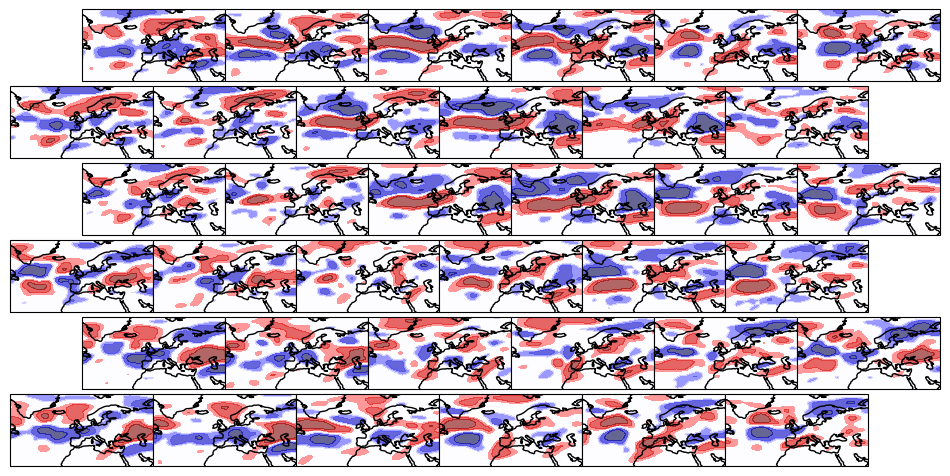

In [4]:
ncol, nrow = net.width, net.height
lon = centers["lon"].values
lat = centers["lat"].values
ratio =  (lat[-1] - lat[0]) / (lon[-1] - lon[0])
fig, axes = honeycomb_panel(ncol, nrow, ratio, dict(projection=ccrs.PlateCarree()))
tbd = []
cmap_wind = mpl.colormaps['seismic']
qlist = [0.025, 0.1, 0.2, 0.8, 0.9, .975]
levels_wind = centers.quantile(qlist).values
norm_wind = BoundaryNorm(levels_wind, cmap_wind.N, extend='both')

for n, (lag, j) in enumerate(product(range(ncol), range(nrow))):
    ax = axes[lag, j]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.contourf(
        lon, lat, centers.isel(x=lag, y=j), cmap=cmap_wind, levels=levels_wind, norm=norm_wind, extend='both', alpha=0.6
    )
    ax.add_feature(COASTLINE)


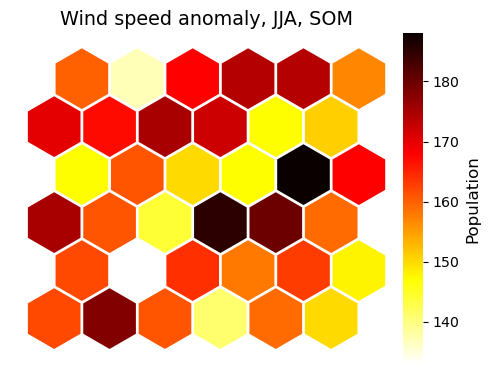

In [5]:
cmap = mpl.colormaps["hot"].reversed()
populations = net.compute_populations()
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Population",
    "title": "Wind speed anomaly, JJA, SOM",
}
fig, ax = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=True,
    **kwargs
)

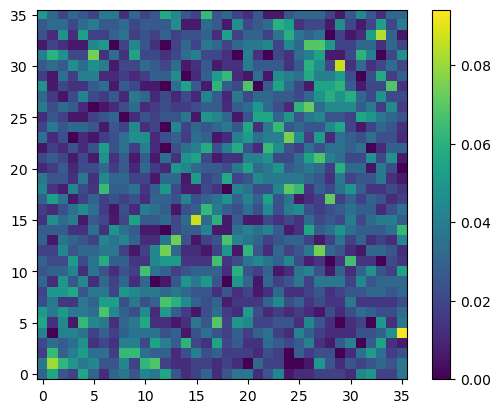

In [6]:
trans_mat = net.compute_transmat(step=3)
fig, ax = plt.subplots()
im = ax.imshow(trans_mat, origin="lower")
fig.colorbar(im, ax=ax)


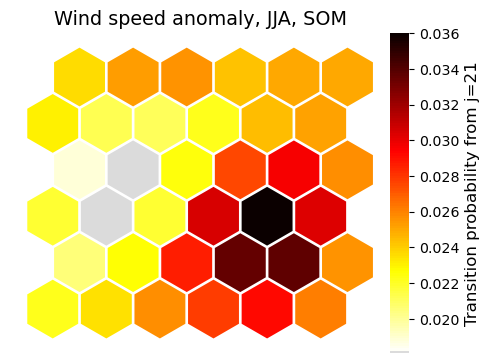

In [7]:
cmap = mpl.colormaps["hot"].reversed()(np.linspace(0, 1, 128))
cmap[:1, :3] = (np.asarray([220, 220, 220]) / 256)[None, :]
cmap = ListedColormap(cmap)
j = np.random.randint(0, net.width * net.height)
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Transition probability from {j=}",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}
probas = trans_mat[:, j]
fig, ax = net.plot_on_map(
    probas,
    smooth_sigma=1,
    show=True,
    **kwargs
)


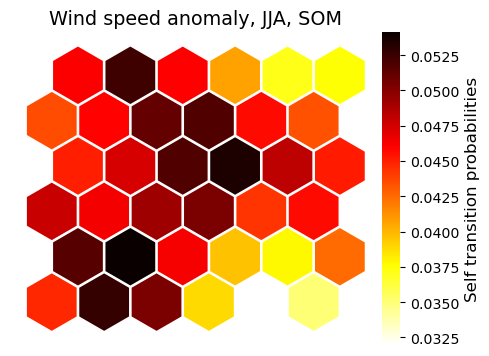

In [8]:
cmap = mpl.colormaps["hot"].reversed()
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Self transition probabilities",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    np.diag(trans_mat),
    smooth_sigma=1,
    show=True,
    **kwargs
)

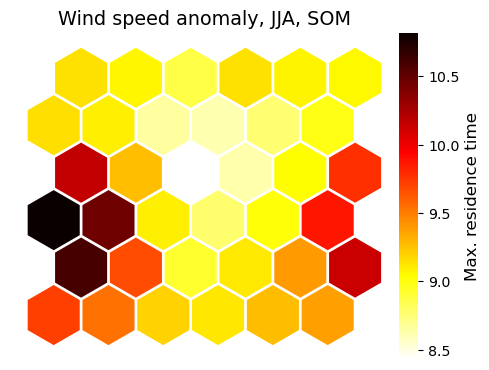

In [9]:
rt_max = net.compute_residence_time('max', smooth_sigma=1)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Max. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=1,
    **kwargs
)

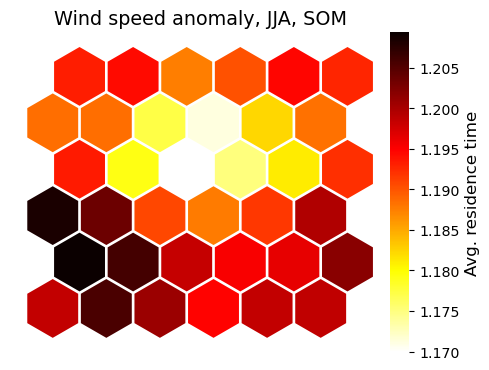

In [10]:
rt_max = net.compute_residence_time('mean', smooth_sigma=0)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Avg. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=1,
    **kwargs
)

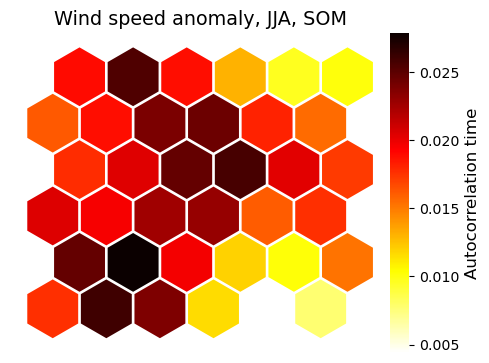

In [11]:
acorr = net.compute_autocorrelation(lag_max=30)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Autocorrelation time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    acorr[3, :],
    smooth_sigma=1,
    **kwargs
)

# SOM vs hotspells

## conditional probas

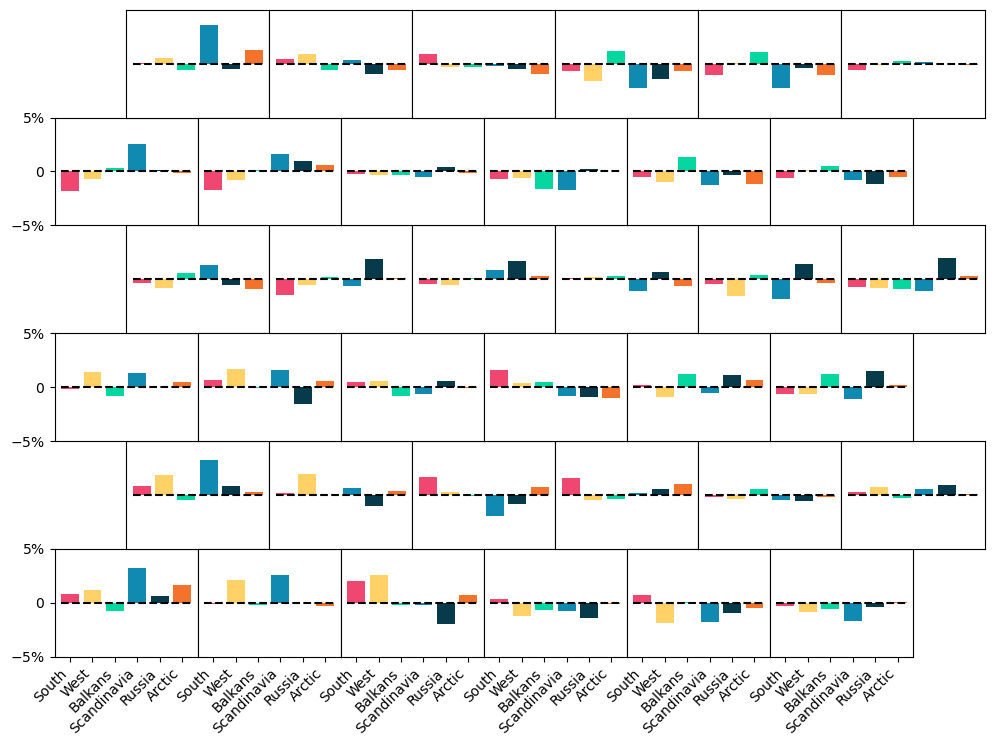

In [13]:
lag = 1
probas = np.sum(np.roll(node_mask[lag:, :, None], shift=lag, axis=0) & hs_mask.values[lag:, None, :], axis=0) / np.sum(hs_mask.values, axis=0)[None, :]
probas -= populations[:, None] / np.sum(populations)
fig, axes = honeycomb_panel(net.width, net.height)
for ax, proba in zip(axes.flatten(), probas):
    ax.bar(np.arange(6), proba, color=COLORS5)
    ax.plot([- 0.4, 5.4], [0, 0], color='black', ls='dashed', zorder=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([-0.05, 0.05])
for ax in axes[0, ::2]:
    ax.set_yticks([-0.05, 0., 0.05], [r'$-5\%$', r'$0$', r'$5\%$'])
for ax in axes[:, 0]:
    ax.set_xticks(np.arange(6), REGIONS, rotation=45, ha='right')

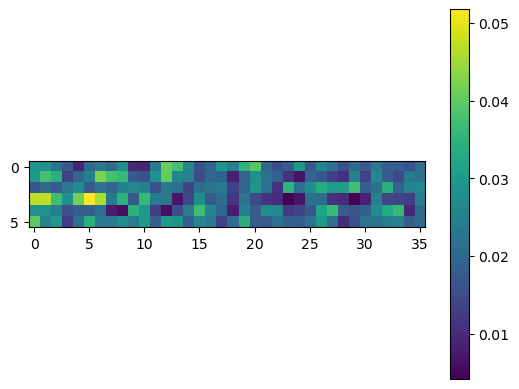

In [14]:
im = plt.imshow(np.sum(hs_mask.values[:, :, None] & node_mask[:, None, :], axis=0) / np.sum(hs_mask.values[:, :, None] | node_mask[:, None, :], axis=0))
plt.colorbar(im)

# lagged time series

In [15]:
hotspells, maxnhs, maxlen = get_hostpells_v2()
node_mask_da_hs = apply_hotspells_mask_v2(hotspells, node_mask_da, maxlen, maxnhs)

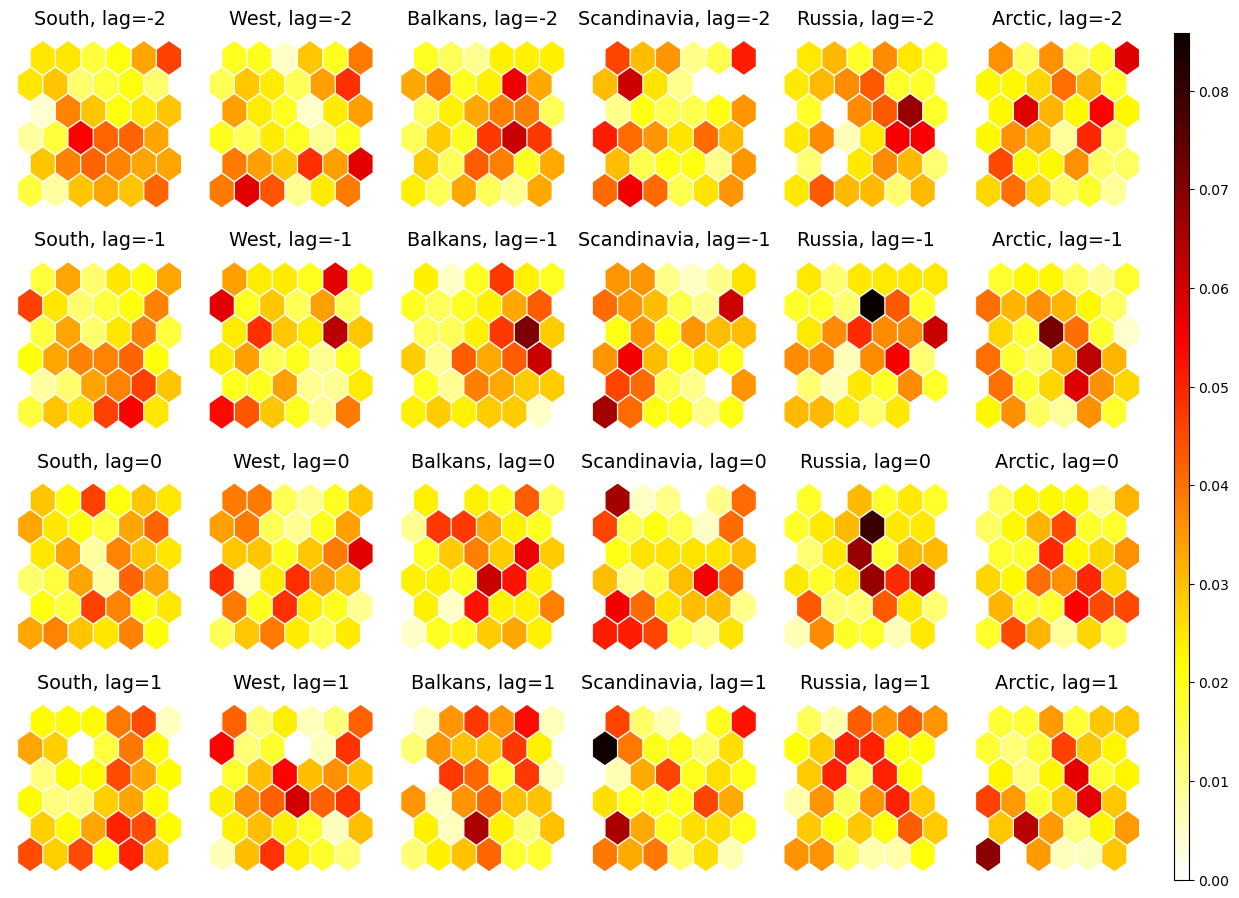

In [16]:
lags = [-2, -1, 0, 1]
to_plot = node_mask_da_hs.sel(day_after_beg=lags).mean(dim='hotspell')
kwargs = {
    "cmap": mpl.colormaps["hot"].reversed(),
    "norm": Normalize(vmin=0, vmax=to_plot.max())
}
im = ScalarMappable(kwargs['norm'], kwargs['cmap'])
fig, axes = plt.subplots(len(lags), len(REGIONS), figsize=(14, 9))
for ilag, lag in enumerate(lags):
    for ax, region in zip(axes[ilag], REGIONS):
        kwargs['title'] = f'{region}, {lag=}'
        fig, ax = net.plot_on_map(
            to_plot.sel(region=region, day_after_beg=lag),
            smooth_sigma=0,
            fig=fig,
            ax=ax,
            show=False,
            draw_cbar=False,
            **kwargs
        )
fig.colorbar(im, ax=axes, shrink=1.0, pad=0.02, aspect=60)
plt.show()

# SOM vs Zoo

In [17]:
varnames = ['Lat', 'Int', 'Tilt', 'Dep', 'Mea']
Zoo = xr.open_dataset(f'{DATADIR}/ERA5/Wind/Low/box_-80_40_20_80/Zoo.nc')
Zoo = Zoo[varnames].isel(time=Zoo.time.dt.season=='JJA')
mu = Zoo.mean(dim='time')
sigma = Zoo.std(dim='time', ddof=1)
node_mask = indices[:, None] == np.arange(net.n_nodes)[None, :]
node_mask_da = xr.DataArray(node_mask, coords={'time': Zoo.time, 'node': np.arange(net.n_nodes)})

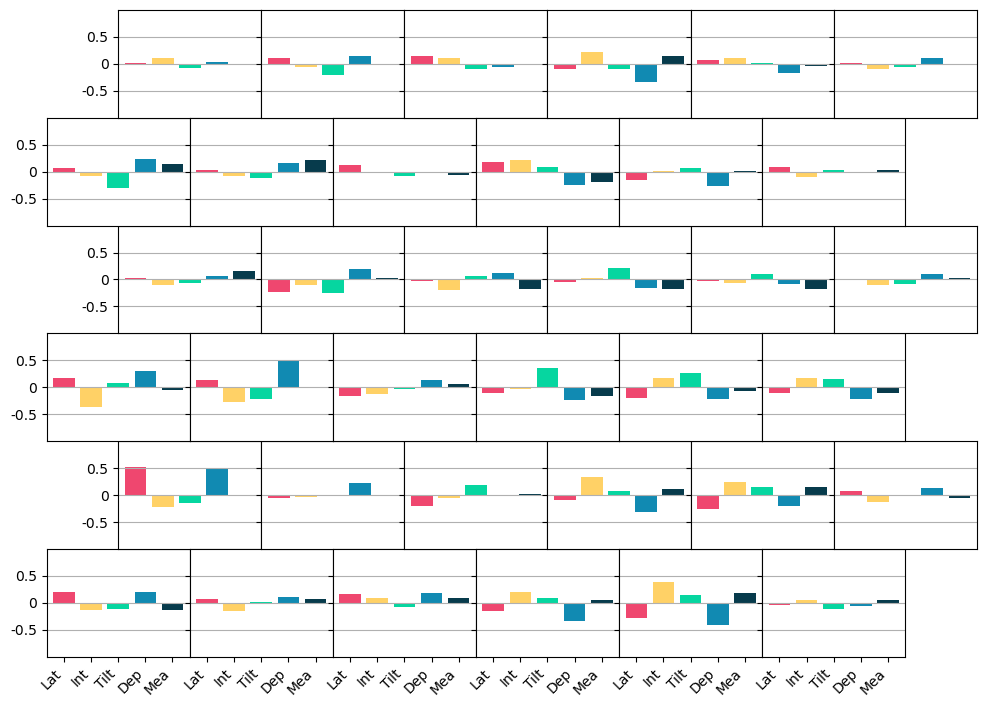

In [18]:
fig, axes = honeycomb_panel(net.width, net.height)
for ax, mask in zip(axes.flatten(), node_mask.T):
    thismu = Zoo.isel(time=mask).mean(dim='time')
    to_plot = [(thismu[vn] - mu[vn]) / sigma[vn] for vn in varnames]
    ax.bar(np.arange(len(varnames)), to_plot, color=COLORS5, label=varnames)
    ax.set_ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([-0.5, 0, 0.5], [''] * 3)
    ax.grid(True, axis='y')
for ax in axes[0, :]:
    ax.set_yticks([-0.5, 0, 0.5], [-0.5, 0, 0.5])
for ax in axes[:, 0]:
    ax.set_xticks(np.arange(5), varnames, rotation=45, ha='right')

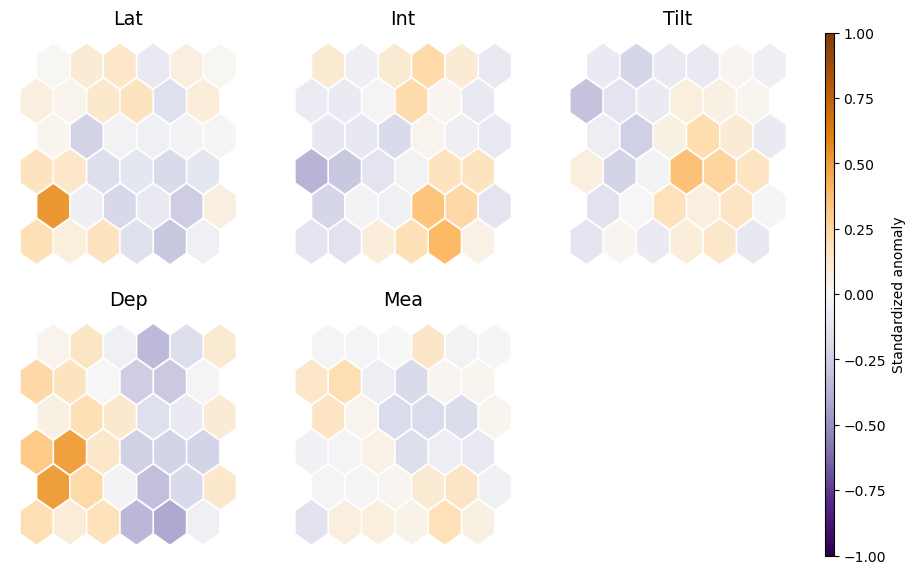

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
mean_on_node = xr.concat([Zoo.isel(time=mask).mean(dim='time') for mask in node_mask.T], dim='node')
axes = axes.flatten()
kwargs = {
    "cmap": mpl.colormaps["PuOr"].reversed(),
    "norm": Normalize(vmin=-1, vmax=1),
}
im = ScalarMappable(kwargs['norm'], kwargs['cmap'])
for ax, varname in zip(axes[:-1], varnames):
    kwargs['title'] = varname
    thismu = Zoo[varname].mean(dim='time')
    to_plot = (mean_on_node[varname] - mu[varname]) / sigma[varname]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        fig=fig,
        ax=ax,
        show=False,
        draw_cbar=False,
        **kwargs
    )
axes[-1].set_visible(False)
fig.colorbar(im, ax=axes, shrink=1.0, pad=0.03, aspect=60, label='Standardized anomaly')
plt.show()

# SOM vs T anomaly

In [5]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')
# da_T = da_T.drop_duplicates(dim='time').interp(time=da_som.time)
Zoo = xr.open_dataset(f'{DATADIR}/ERA5/Wind/Low/box_-80_40_20_80/Zoo.nc')
da_s = exp_som.open_da('anomaly', 'JJA')


In [6]:
multimask = (indices[:, None] == np.arange(net.n_nodes)[None, :]).reshape(-1, net.width, net.height)

In [7]:
coords = {
    'x': centers['x'],
    'y': centers['y'],
    'lat': da_T['lat'],
    'lon': da_T['lon']
}
center_temps = xr.DataArray(np.empty((net.width, net.height, *da_T.shape[1:])), coords=coords)
for i, j in product(range(net.width), range(net.height)):
    center_temps[i, j] = da_T.isel(time=multimask[:, i, j]).mean(dim='time')

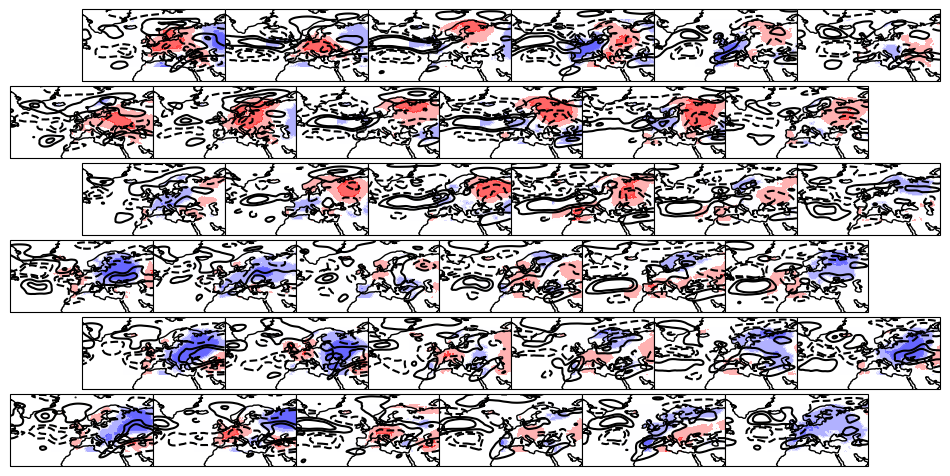

In [8]:
ncol, nrow = net.width, net.height
ratio = (da_som.lat[-1] - da_som.lat[0]) / (da_som.lon[-1] - da_som.lon[0])  * nrow / ncol
fig, axes = honeycomb_panel(ncol, nrow, ratio, dict(projection=ccrs.PlateCarree()))
tbd = []
lont = center_temps["lon"].values
latt = center_temps["lat"].values
lonw = centers["lon"].values
latw = centers["lat"].values
cmap_temp = mpl.colormaps['bwr']
cmap_wind = mpl.colormaps['BrBG']
qlist = [0.025, 0.15, 0.85, .975]
levels_temp = center_temps.quantile(qlist).values
norm_temp = BoundaryNorm(levels_temp, cmap_temp.N, extend='both')
levels_wind = centers.quantile(qlist).values

for n, (i, j) in enumerate(product(range(ncol), range(nrow))):
    ax = axes[i, j]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.contourf(
        lont, latt, center_temps.isel(x=i, y=j), cmap=cmap_temp, levels=levels_temp, norm=norm_temp, extend='both', alpha=0.6
    )
    ax.contour(
        lonw, latw, centers.isel(x=i, y=j), levels=levels_wind, colors='black', linewidths=1.5,
    )
    ax.add_feature(COASTLINE)
# if i % 2 == 0:
#     tbd.append(fig.add_subplot(gs[i, -1]).set_visible(False))
# else:
#     tbd.append(fig.add_subplot(gs[i, 0]).set_visible(False))


## Intransivity

In [84]:
allnodes = np.arange(net.n_nodes)
indices_mask = indices[:, None] == allnodes[None, :]
indices_mask = xr.DataArray(indices_mask, coords={'time': da_som.time.values, 'node': allnodes})

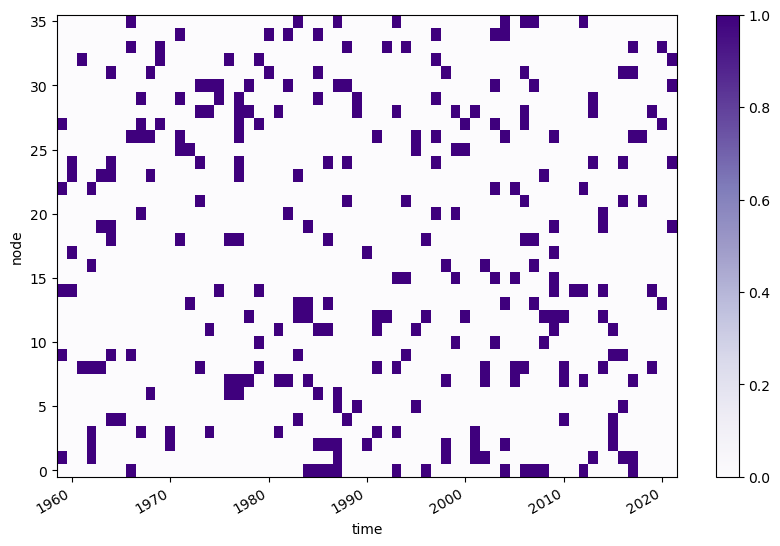

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list(
    "gr",
    [
        [21 / 256, 176 / 256, 26 / 256, 1],
        [1, 1, 1, 1],
        [229 / 256, 0, 0, 1],
    ],
    N=50,
)
to_plot = indices_mask.resample(time='1YS').any(dim='time').T
(~to_plot).plot.pcolormesh(cmap='Purples') #, linewidth=.5, edgecolors='white')


<xarray.DataArray 'year' (time: 63)>
array([1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1960-01-01 ... 2021-01-01

In [128]:
from kmedoids import KMedoids

In [131]:
n_clu = 7
clusters = KMedoids(n_clu).fit_predict(to_plot.values.T.astype(float))
years = to_plot.time.dt.year
fig, axes = plt.subplots(1, n_clu, sharey=True, figsize=(14, 5))
for i in range(n_clu):
    ouais = ~to_plot.isel(time=clusters==i).values
    x = np.arange(ouais.shape[1])
    theseyears = years[clusters==i].values
    cmap = 'Purples'
    if 2003 in theseyears or 2010 in theseyears:
        cmap = 'Reds'
    ax = axes[i]
    ax.pcolormesh(ouais, cmap=cmap)
    ax.set_xticks(x + 0.5, theseyears, rotation=90)

# OPPS

In [4]:
eigenvals, OPPs, path = exp_som.compute_opps(180, return_realspace=True)
raw_OPPs = load_pickle(path)['OPPs']
X, da = exp_som.prepare_for_clustering()
OPP_timeseries = exp_som.opp_transform(X, 180)
mask_high_val = OPP_timeseries > 2
mask_low_val = OPP_timeseries < -2
OPP_mask = np.argmax(OPP_timeseries, axis=1)[:, None] == np.arange(OPP_timeseries.shape[1])[None, :]


## Misc

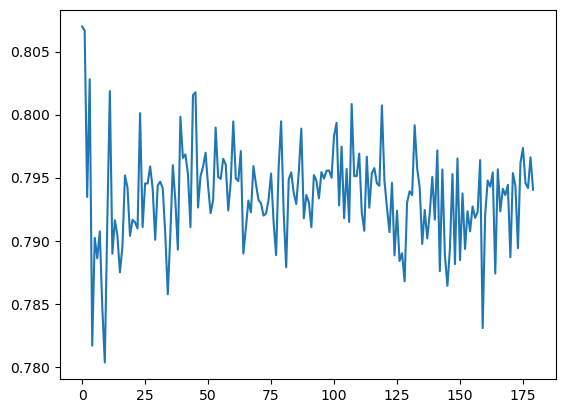

In [38]:
plt.plot(np.mean(np.abs(OPP_timeseries), axis=0))

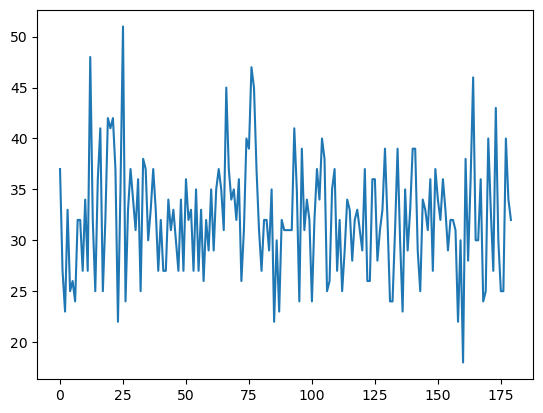

In [39]:
plt.plot(np.sum(OPP_mask, axis=0))

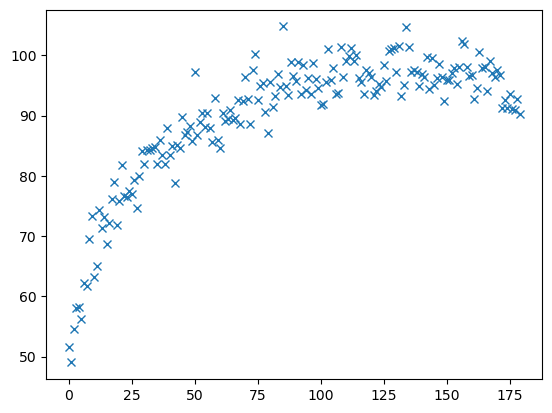

In [40]:
plt.plot(np.average(np.broadcast_to(np.arange(180)[None, :], raw_OPPs.shape), weights=np.abs(raw_OPPs), axis=1), 'x')

## OPPs vs. hotspells

In [10]:
OPP_timeseries_da = xr.DataArray(OPP_timeseries, coords={'time': da.time, 'OPP': np.arange(OPP_timeseries.shape[1])})
hotspells, maxnhs, maxlen = get_hostpells_v2()
OPP_mask_da = apply_hotspells_mask_v2(hotspells, OPP_timeseries_da, maxlen, maxnhs)
num_samples = (~OPP_mask_da.isel(OPP=0).isnull()).sum(dim='hotspell')

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


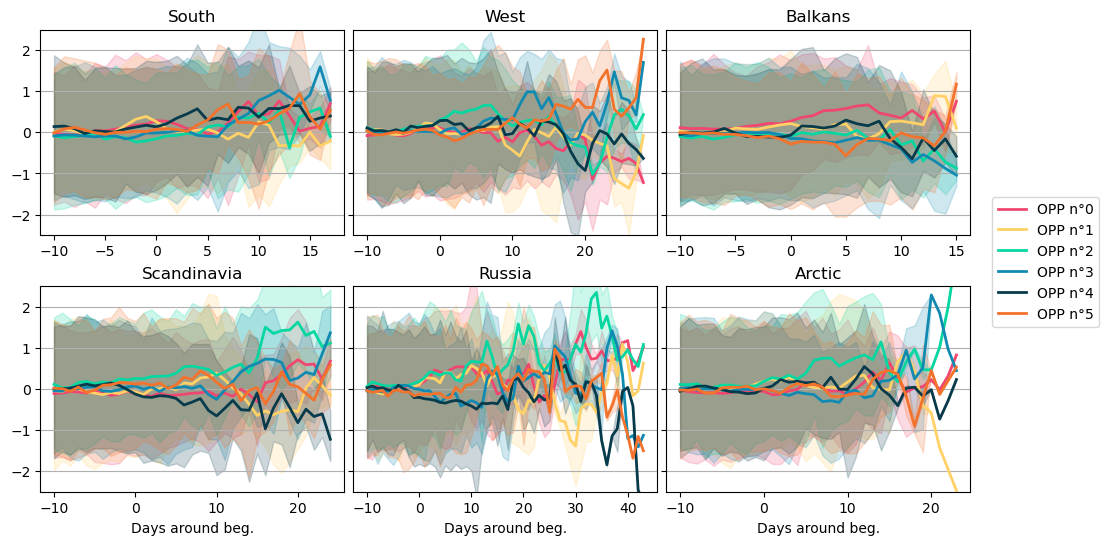

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=0.03, hspace=0.25)
axes = axes.flatten()
means = OPP_mask_da.isel(OPP=np.arange(6)).mean(dim='hotspell')
quantiles = OPP_mask_da.isel(OPP=np.arange(6)).quantile([0.05, 0.95], dim='hotspell')
for i, (ax, region) in enumerate(zip(axes, REGIONS)):
    for OPP, color in zip(range(6), COLORS5):
        this = means.sel(region=region).isel(OPP=OPP)
        maxidx = np.sum(~np.isnan(this.values))
        this = this[:maxidx]
        q1, q2 = quantiles.sel(region=region).isel(OPP=OPP)[:, :maxidx]
        ax.plot(this.day_after_beg, this, lw=2, color=color, label=f'OPP n°{OPP}')
        ax.fill_between(this.day_after_beg, q1, q2, color=color, alpha=0.2)
        ax.set_ylim([-2.5, 2.5])
        if i % 3 == 0:
            ax.set_yticks([-2, -1, 0, 1, 2])
        else:
            ax.set_yticks([-2, -1, 0, 1, 2], [''] * 5)
        if i > 2:
            ax.set_xlabel('Days around beg.')
        ax.grid(True, axis='y')
        ax.set_title(region)
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1.05, 1.12))

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


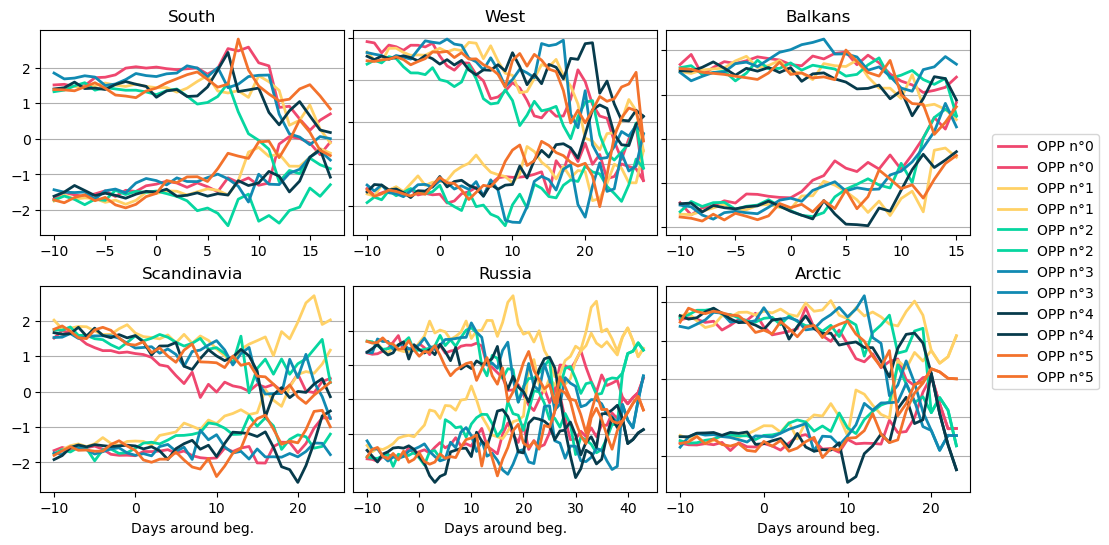

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=0.03, hspace=0.25)
axes = axes.flatten()
means = OPP_mask_da.isel(OPP=np.arange(6)).mean(dim='hotspell')
quantiles = OPP_mask_da.isel(OPP=np.arange(6)).quantile([0.05, 0.95], dim='hotspell')
for i, (ax, region) in enumerate(zip(axes, REGIONS)):
    for OPP, color in zip(range(6), COLORS5):
        this = means.sel(region=region).isel(OPP=OPP)
        maxidx = np.sum(~np.isnan(this.values))
        this = this[:maxidx]
        q1, q2 = quantiles.sel(region=region).isel(OPP=OPP)[:, :maxidx]
        ax.plot(this.day_after_beg, q1, lw=2, color=color, label=f'OPP n°{OPP}')
        ax.plot(this.day_after_beg, q2, lw=2, color=color, label=f'OPP n°{OPP}')
        # ax.fill_between(this.day_after_beg, q1, q2, color=color, alpha=0.2)
        # ax.set_ylim([-2.5, 2.5])
        if i % 3 == 0:
            ax.set_yticks([-2, -1, 0, 1, 2])
        else:
            ax.set_yticks([-2, -1, 0, 1, 2], [''] * 5)
        if i > 2:
            ax.set_xlabel('Days around beg.')
        ax.grid(True, axis='y')
        ax.set_title(region)
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1.05, 1.12))

## OPP clusterplots

(<Figure size 1950x650 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7fa55504c490>)

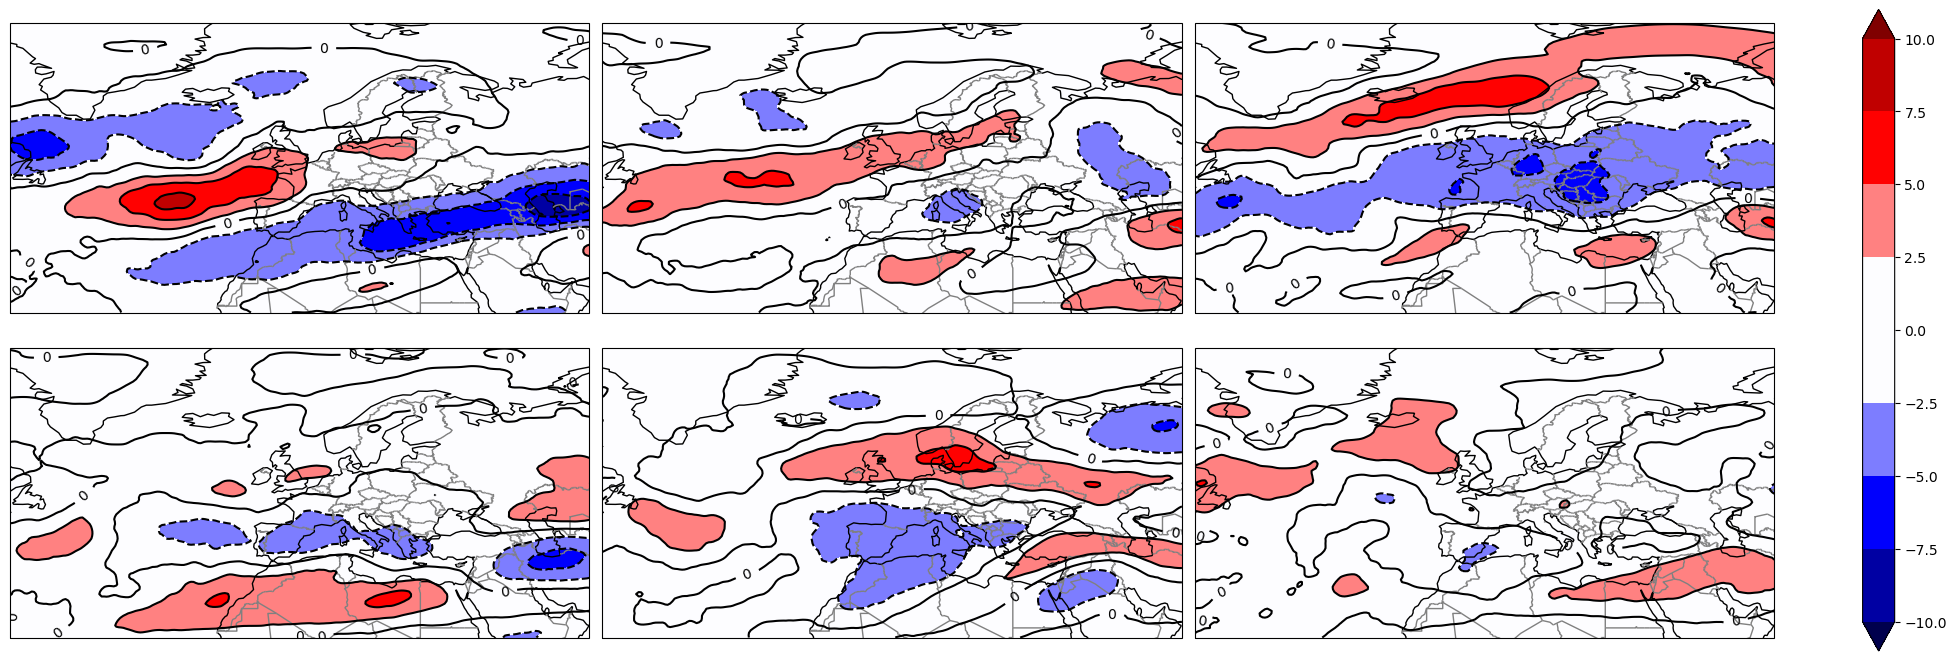

In [12]:
to_plot = [da.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
clusterplot(2, 3, to_plot, 5, 10, clabels=[0])

(<Figure size 1950x650 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7fa555312350>)

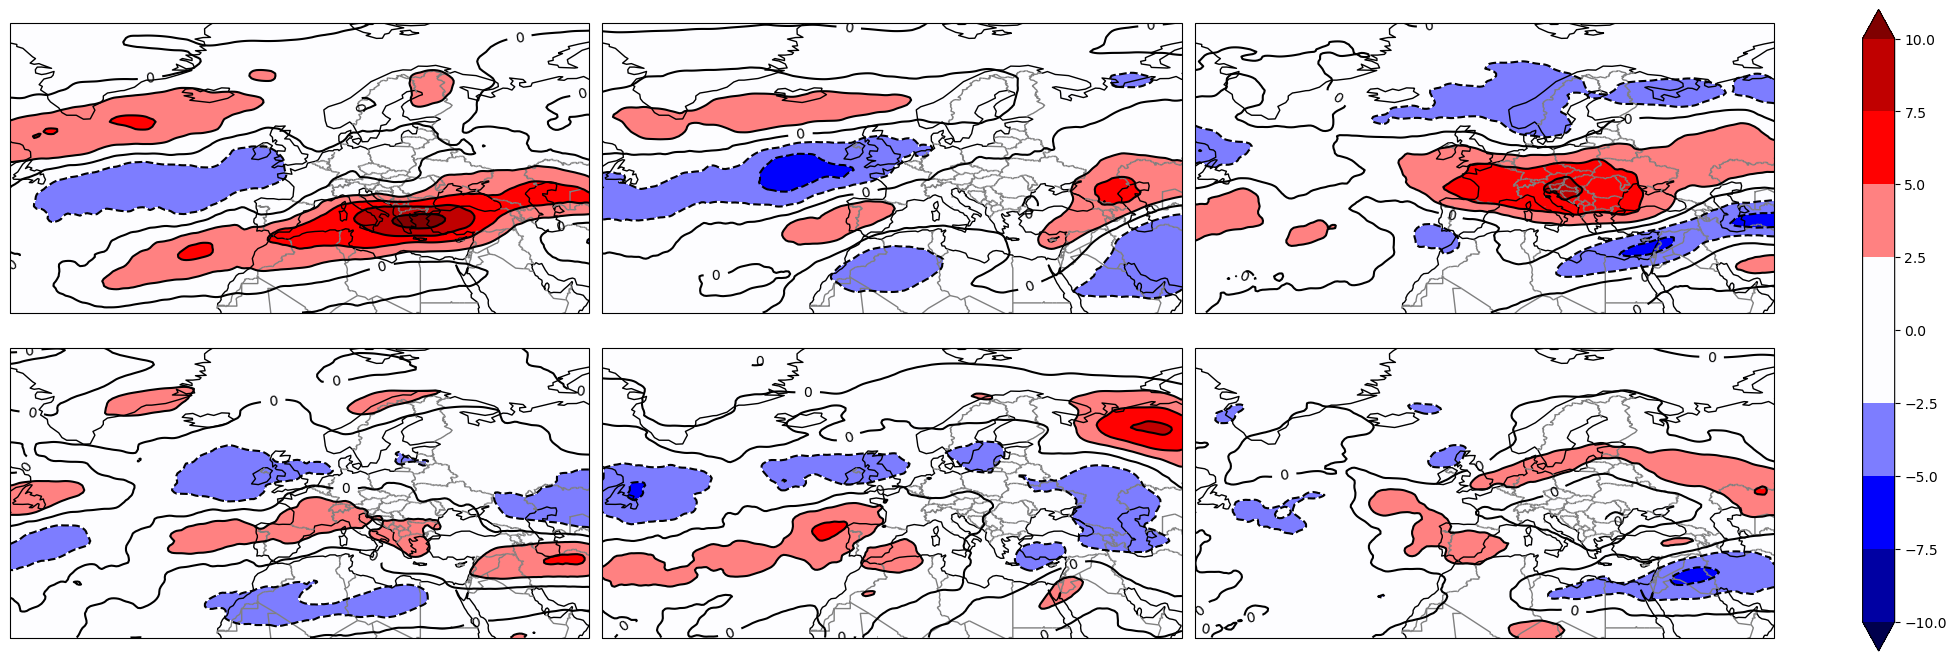

In [13]:
to_plot = [da.isel(time=mask_low_val[:, i]).mean(dim='time') for i in range(6)]
clusterplot(2, 3, to_plot, 5, 10, clabels=[0])

(<Figure size 1950x650 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7fa55726c490>)

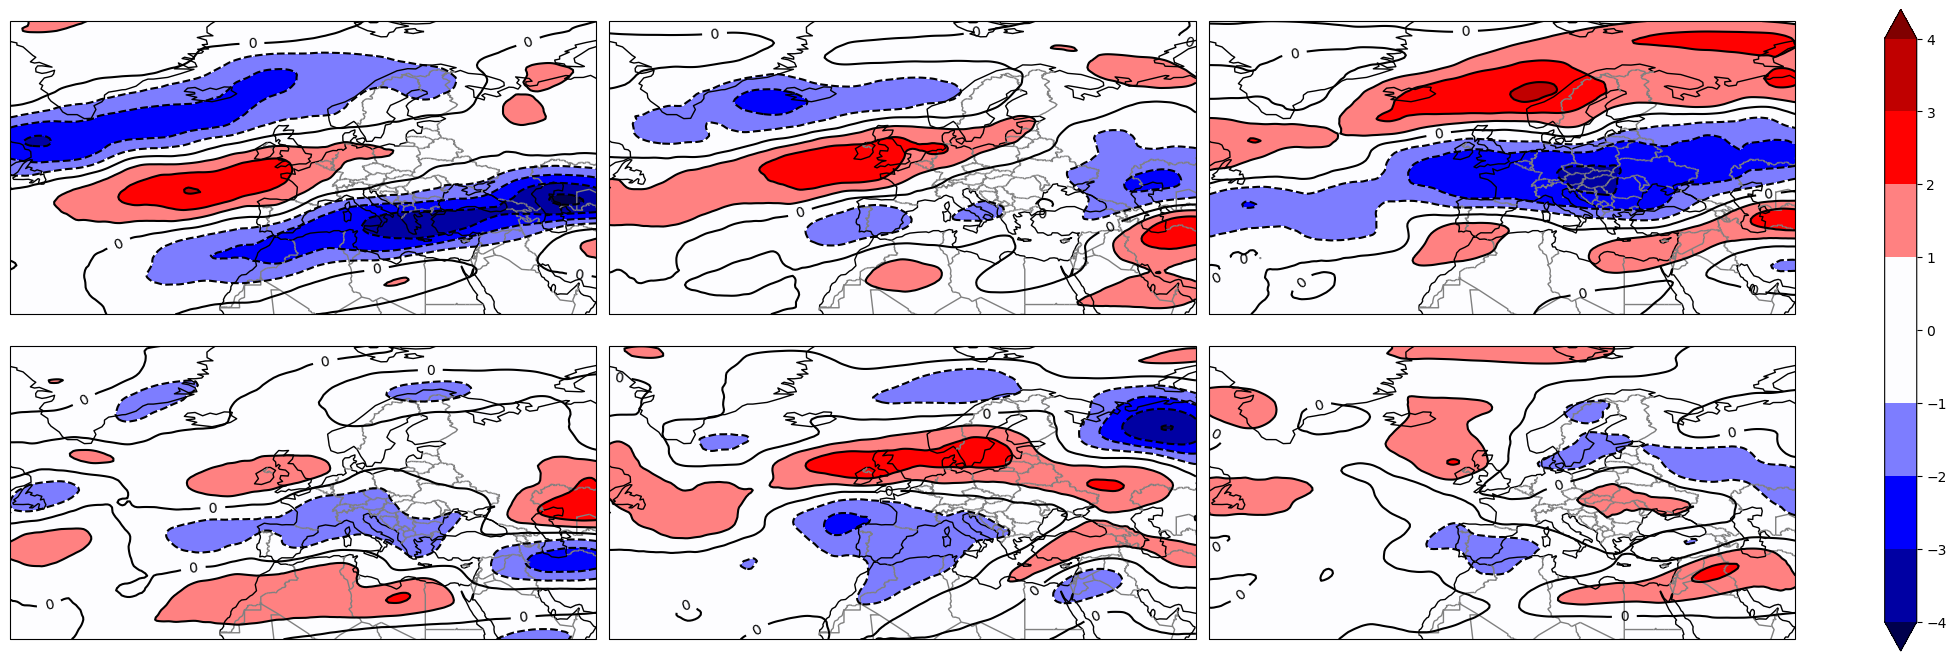

In [14]:
to_plot = OPPs[:6]
clusterplot(2, 3, to_plot, 5, 4, clabels=[0])

(<Figure size 1950x650 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7fa5572a4490>)

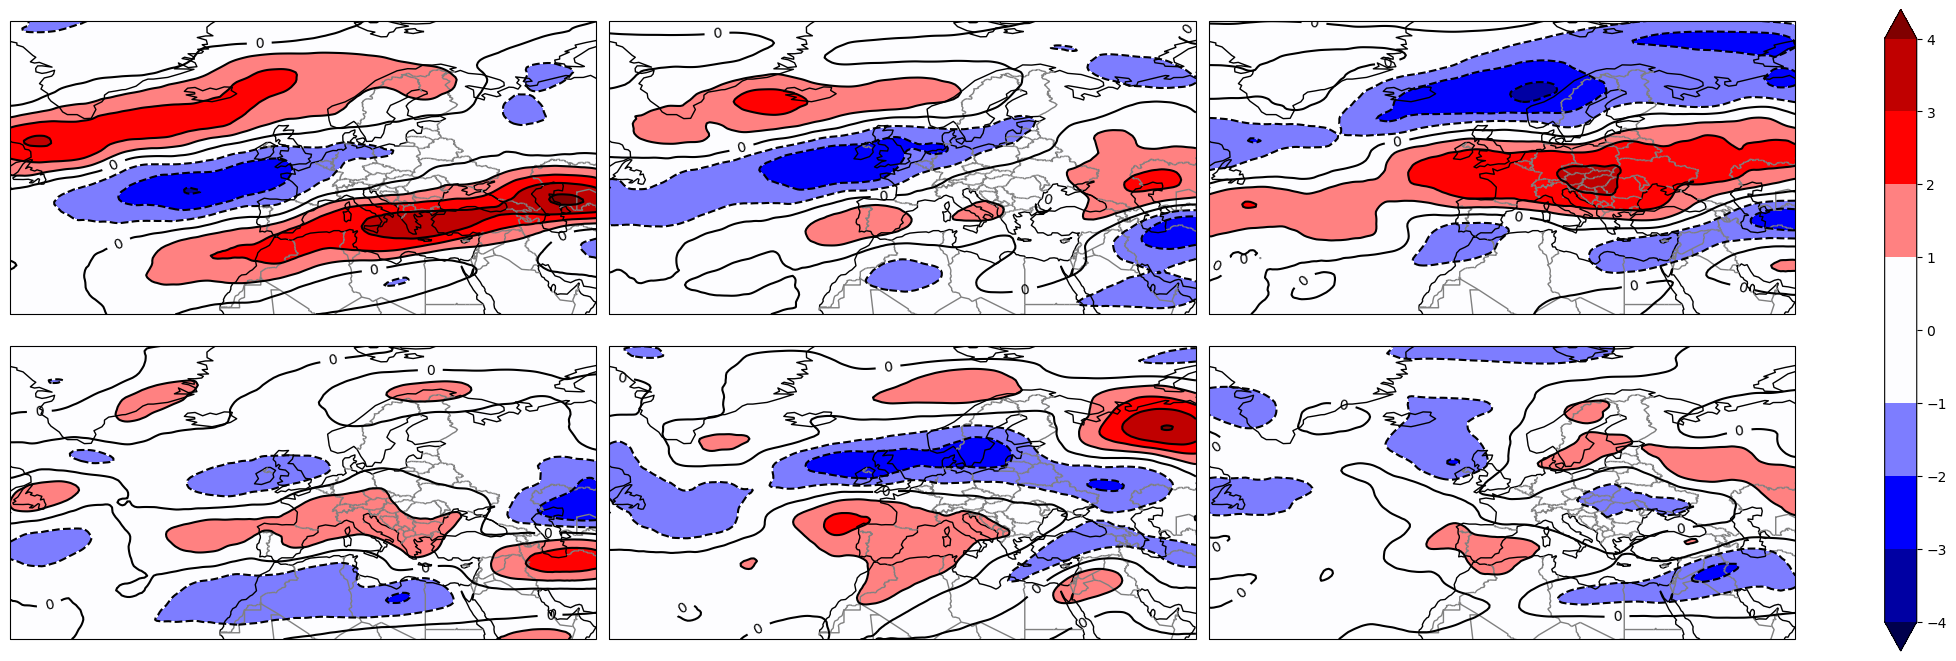

In [15]:
to_plot = OPPs[:6]
clusterplot(2, 3, -to_plot, 5, 4, clabels=[0])

## OPPs versus T anomalies

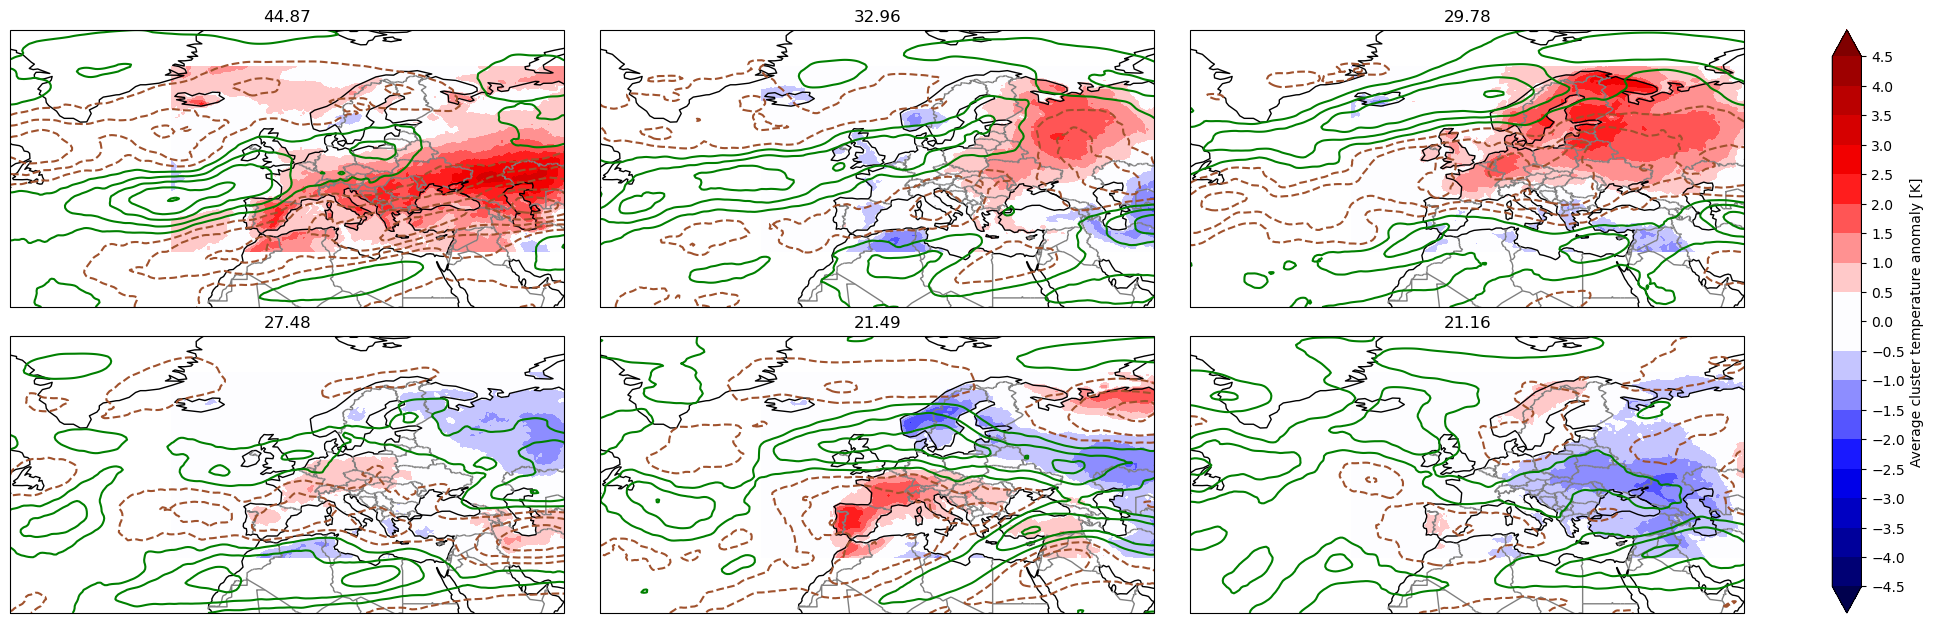

In [16]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')
da_T = da_T.drop_duplicates(dim='time').interp(time=da_som.time)
to_plot = [da_T.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 10, 4.5, clabels=None, contours=False, cbar_ylabel='Average cluster temperature anomaly [K]')
to_plot = [da.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
levels = 12
levels2 = int(levels / 2)
colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt, eigenval in zip(axes, to_plot, eigenvals):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-10, vmax=10, colors=colors, linestyles=linestyles)
    ax.set_title(f'{eigenval:.2f}')

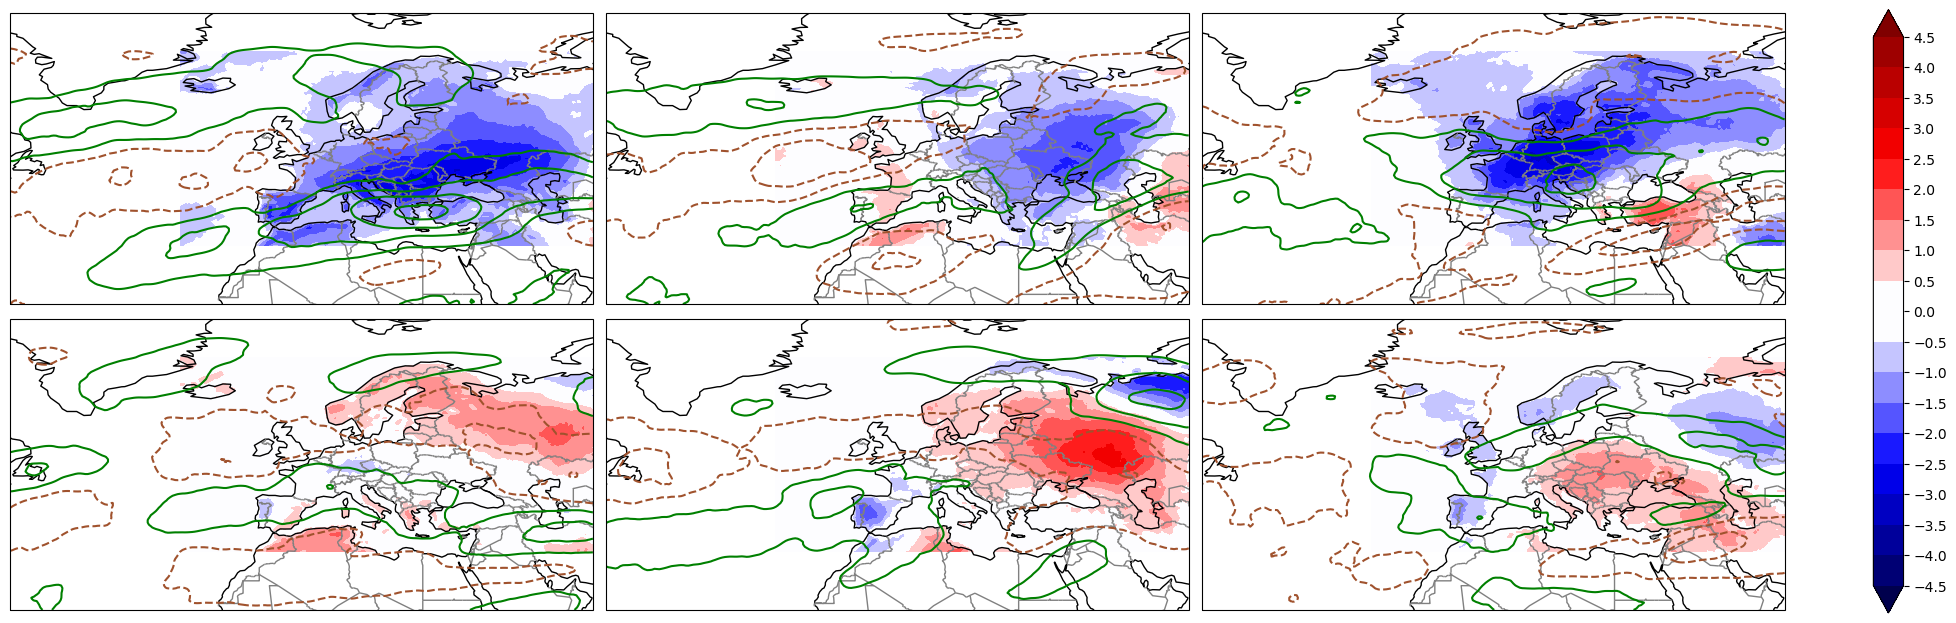

In [17]:
to_plot = [da_T.isel(time=mask_low_val[:, i]).mean(dim='time') for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 10, 4.5, clabels=None, contours=False)
to_plot = [da.isel(time=mask_low_val[:, i]).mean(dim='time') for i in range(6)]
levels = 8
levels2 = int(levels / 2)
colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt in zip(axes, to_plot):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-10, vmax=10, colors=colors, linestyles=linestyles)

# OPPs vs prec anomalies

In [2]:
da = xr.open_dataset(f'{DATADIR}/ERA5/Temperature/2m/dailymean/t.nc', chunks={"time": -1, "lon": -1, "lat": 20})['t']

In [3]:
da

<xarray.DataArray 't' (time: 23011, lat: 361, lon: 720)>
dask.array<open_dataset-7522b2c4767d0a34058f61fe11be2f1bt, shape=(23011, 361, 720), dtype=float32, chunksize=(23011, 20, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01T09:00:00 ... 2021-12-31T09:00:00
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Attributes:
    long_name:     2 metre temperature
    units:         K
    cell_methods:  time: mean

In [5]:
# anom, clim = compute_anomaly(da, return_clim=True)
# clim.compute(n_workers=8)
# print('done')
# clim.to_netcdf(f'{DATADIR}/ERA5/Temperature/2m/dailymean/t_clim.nc')
# del clim 
# gc.collect()
anom=anom.compute(n_workers=8)
print('done')
anom.to_netcdf(f'{DATADIR}/ERA5/Temperature/2m/dailymean/t_anomaly.nc')

: 

: 

In [ ]:
anom = xrft.detrend(anom, "time", "linear").compute(n_workers=8)
anom.to_netcdf(f'{DATADIR}/ERA5/Temperature/2m/dailymean/t_detrended.nc')

In [ ]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')
da_T = da_T.drop_duplicates(dim='time').interp(time=da_som.time)
to_plot = [da_T.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 10, 4.5, clabels=None, contours=False, cbar_ylabel='Average cluster temperature anomaly [K]')
to_plot = [da.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
levels = 12
levels2 = int(levels / 2)
colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt, eigenval in zip(axes, to_plot, eigenvals):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-10, vmax=10, colors=colors, linestyles=linestyles)
    ax.set_title(f'{eigenval:.2f}')

# Regionalized T anomalies

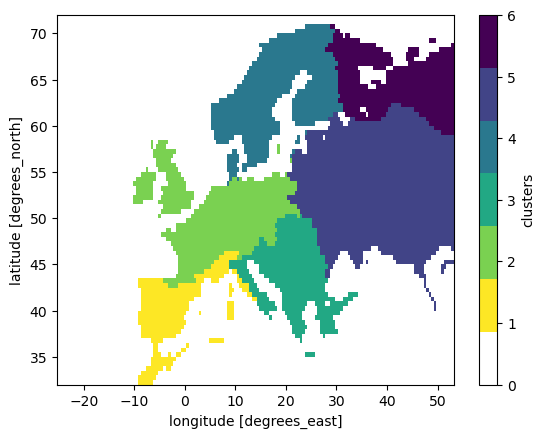

In [18]:
duncan_mask = np.abs(xr.open_dataarray(f'{DATADIR}/ERA5/clusters_n6_eu_3w-def_correct-order.nc').fillna(0))
cmap = mpl.colormaps['viridis'].reversed()(np.linspace(0, 1, 6))
cmap = np.vstack([[1, 1, 1, 1], cmap])
cmap = ListedColormap(cmap)
duncan_mask.plot(cmap=cmap)

In [19]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')
da_T = da_T.interp(lon=duncan_mask.lon, lat=duncan_mask.lat).assign_coords({'mask': duncan_mask})

In [20]:
coords = {'time': da_T.time, 'region': REGIONS, 'quant': ['mean', 'median', 'min', 'max', 'q05', 'q95']}
timeseries = xr.DataArray(np.zeros([len(val) for val in coords.values()]), coords=coords)
for i, region in enumerate(REGIONS):
    base = da_T.where(da_T.mask==i + 1)
    timeseries.loc[:, region, 'mean'] = base.mean(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'median'] = base.median(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'min'] = base.min(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'max'] = base.max(dim=['lon', 'lat'])
    timeseries.loc[:, region, 'q05'] = base.quantile(0.05, dim=['lon', 'lat'])
    timeseries.loc[:, region, 'q95'] = base.quantile(0.95, dim=['lon', 'lat'])
series2 = timeseries.values.reshape(-1, 36)
series1 = OPP_timeseries
corr = np.corrcoef(series1, series2, rowvar=False)
n_opp = OPP_timeseries.shape[1]
xcorr = corr[n_opp:, :n_opp]
xcorr = xr.DataArray(
    xcorr.reshape(6, 6, 180), 
    coords={
        'region': REGIONS, 'quant': ['mean', 'median', 'min', 'max', 'q05', 'q95'], 'OPP': np.arange(n_opp)},
)

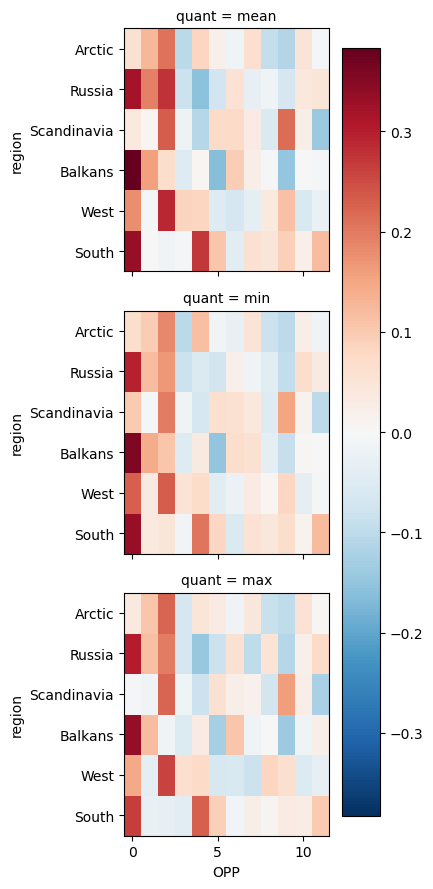

In [21]:
xcorr.isel(OPP=np.arange(12), quant=[0, 2, 3]).plot.imshow(row='quant')

In [22]:
import CDSK as ck

In [55]:
ld, theta, alpha = ck.dynamical_local_indexes(net.data)

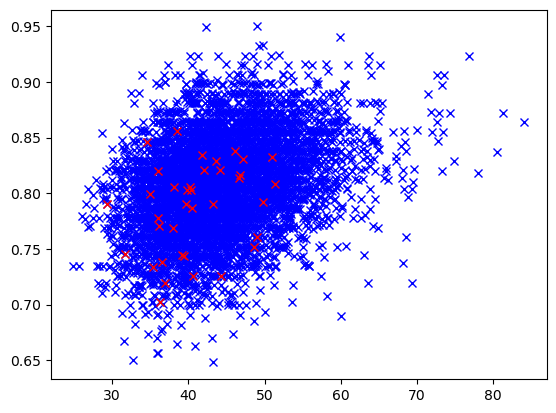

In [56]:
plt.plot(ld[:, 0, 0], theta[:, 0, 0], 'bx')
plt.plot(ld[OPP_mask[:, 0], 0, 0], theta[OPP_mask[:, 0], 0, 0], 'rx')

In [57]:
ds_dsi = xr.Dataset(coords={'time': da_som.time.values})
ds_dsi['ld'] = ('time', ld.flatten())
ds_dsi['theta'] = ('time', theta.flatten())

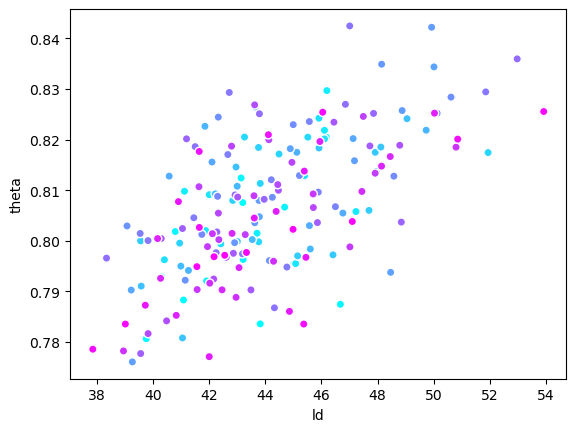

In [58]:
ds_dsi.resample(time='1M').mean(dim='time').plot.scatter(x='ld', y='theta', hue='time', cmap='cool', add_colorbar=False, add_legend=False)

In [70]:
mu_ld, sigma_ld = np.mean(ld), np.std(ld)
mu_theta, sigma_theta = np.mean(theta), np.std(theta)

mean_lds = np.asarray([np.mean(ld[mask]) for mask in node_mask.T])
mean_thetas = np.asarray([np.mean(theta[mask]) for mask in node_mask.T])

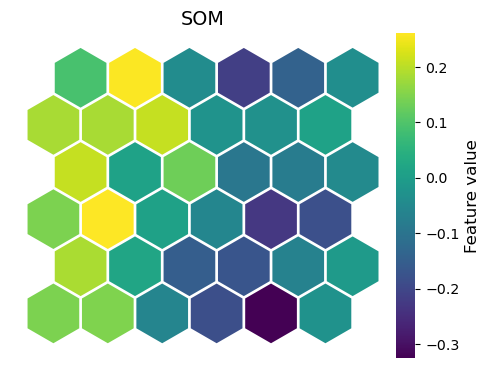

(<Figure size 500x500 with 2 Axes>, <Axes: title={'center': 'SOM'}>)

In [71]:
net.plot_on_map((mean_lds - mu_ld) / sigma_ld)

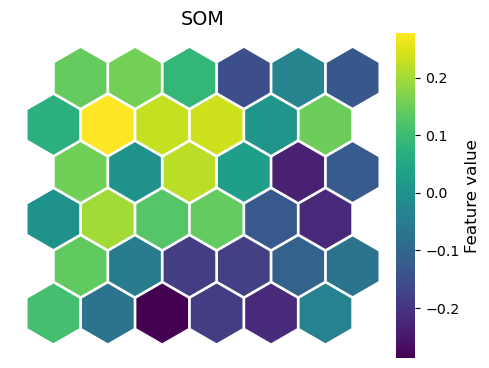

(<Figure size 500x500 with 2 Axes>, <Axes: title={'center': 'SOM'}>)

In [72]:
net.plot_on_map((mean_thetas - mu_theta) / sigma_theta)